In [1]:
import matplotlib.pyplot as plt


def plot_function(fn, space, fig=None, ax=None, scatter_markers=None, output_index=-1):
    # fn: function to plot
    # output_index: -1 if the output of the function is a single value; if the outputs are tuples index of the output that should be plotted
    res = fn(space)
    if output_index >= 0:
        res = res[output_index]
    res = res.to("cpu").detach()
    if fig is None or ax is None:
        fig, ax = plt.subplots(nrows=1)
    # ax.matshow(res)
    # https://matplotlib.org/stable/gallery/images_contours_and_fields/irregulardatagrid.html#sphx-glr-gallery-images-contours-and-fields-irregulardatagrid-py
    cntr = ax.contourf(
        xi,
        yi,
        res.reshape(int(len(res) ** (1 / 2)), int(len(res) ** (1 / 2))),
        levels=50,
    )
    fig.colorbar(cntr, ax=ax)
    if scatter_markers is not None:
        scatter_markers = scatter_markers
        ax.scatter(
            x=scatter_markers[:, 1], y=scatter_markers[:, 0], c="red", marker="x"
        )
    return fig, ax

# Active Learning Loop

In [2]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
import numpy as np

n_iterations = 10  # TODO: replace with budget
grid_size = 10
float_prec = 64
n_samples = 3
maximize = False

# define candidate set
xi = np.arange(0, grid_size)
yi = np.arange(0, grid_size)
grid = np.array(np.meshgrid(xi, yi))
grid_flat = torch.tensor(grid.T, dtype=torch.float64).reshape(-1, 2)
from dataset.dataset import Branin_Data
candidate_set, _ = Branin_Data(grid_size, grid_flat)[:]
xi = xi / grid_size
yi = yi / grid_size

import matplotlib.colors as cm

# colors = ["red", "blue", "green", "orange", "brown", "pink"]
colors = plt.get_cmap("Reds")

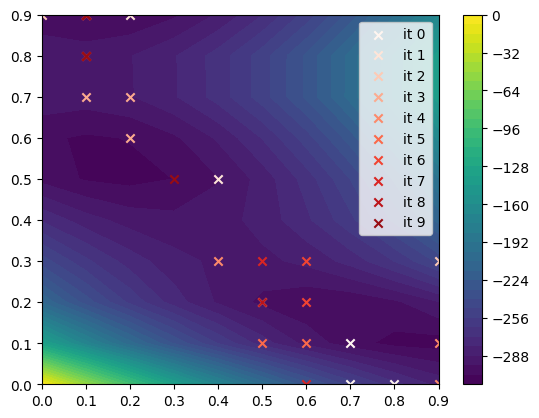

Text(0.5, 1.0, 'Best Score in each iteration')

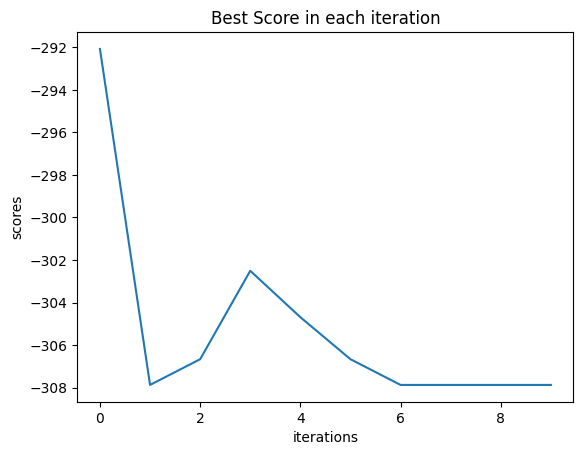

In [5]:
from dataset.dataset import BraninDatasetHandler
from surrogate.surrogate import SingleTaskGPRegressor
from sampler.sampler import GreedySampler, RandomSampler
from filter.filter import Filter, OracleFilter
from gflownet.proxy.box.branin import Branin


# Dataset
dataset_handler = BraninDatasetHandler(
    grid_size=grid_size,
    train_path="./storage/branin/data_%i_train.csv" % grid_size,
    train_fraction=1.0,
    float_precision=float_prec,
)
# Oracle
oracle = Branin(
    fidelity=1, do_domain_map=True, device=device, float_precision=float_prec
)
# Filter
filter = Filter()
# filter = OracleFilter(oracle)

if plot_function is not None:
    fig, ax = plot_function(oracle, candidate_set.clone().to(device))

best_scores = []

for i in range(n_iterations):

    train_data, test_data = dataset_handler.get_dataloader()
    # print("iteration", i)
    # Surrogate (e.g., Bayesian Optimization)
    # starts with a clean slate each iteration
    surrogate = SingleTaskGPRegressor(
        float_precision=float_prec, device=device, maximize=maximize
    )
    surrogate.fit(train_data)

    # Sampler (e.g., GFlowNet, or Random Sampler)
    # also starts with a clean slate; TODO: experiment with NOT training from scratch
    # sampler = RandomSampler(surrogate)
    sampler = GreedySampler(surrogate)
    sampler.fit()  # only necessary for samplers that train a model

    samples = sampler.get_samples(n_samples * 3, candidate_set=candidate_set.clone().to(device))
    filtered_samples = filter(
        n_samples=n_samples, candidate_set=samples.clone(), maximize=maximize
    )

    if ax is not None:
        ax.scatter(
            x=filtered_samples[:, 0].cpu(),
            y=filtered_samples[:, 1].cpu(),
            c=cm.to_hex(colors(i / n_iterations)),
            marker="x",
            label="it %i" % i,
        )

    scores = oracle(filtered_samples.clone())
    dataset_handler.update_dataset(filtered_samples.cpu(), scores.cpu())
    best_scores.append(scores.min().cpu())

plt.legend()
plt.show()

plt.plot(best_scores)
plt.xlabel("iterations")
plt.ylabel("scores")
plt.title("Best Score in each iteration")

# Test individual components

In [3]:
import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
print(device)
import numpy as np

grid_size = 10 #100
test_states = torch.tensor([[0.5,0.5]])
test_scores = torch.tensor([-150.0])
n_samples = 5

baseline_states = torch.tensor([[.0*grid_size,  .0*grid_size],
        [.0*grid_size, .4*grid_size],
        [.4*grid_size,  .0*grid_size],
        [.8*grid_size, .8*grid_size]])

# define grid space
xi = np.arange(0,1,1/grid_size)
yi = np.arange(0,1,1/grid_size)
grid = np.array(np.meshgrid(xi,yi))
grid_flat = torch.tensor(grid.T, dtype=torch.float64).reshape(-1,2).to(device)
    

cuda


In [4]:
# dataset
from dataset.dataset import BraninDatasetHandler
dataset_handler = BraninDatasetHandler(grid_size=grid_size, train_path="./storage/branin/data_%i_train.csv"%grid_size, train_fraction=1.0, device=device, float_precision=64)

# testing dataset
# dataset_handler.update_dataset(test_states.to(device), test_scores.to(device))
print(dataset_handler.train_data.X_data, dataset_handler.train_data.y_data)
print(dataset_handler.train_data[:])
# train_loader, test_loader = dataset_handler.get_dataloader()
# for X, y in train_loader:
#     print(X, y)

tensor([[0., 0.],
        [0., 4.],
        [4., 0.],
        [8., 8.]], device='cuda:0', dtype=torch.float64) tensor([  -0.8709, -171.1192, -273.2218, -174.8874], device='cuda:0',
       dtype=torch.float64)
(tensor([[0.0000, 0.0000],
        [0.0000, 0.4000],
        [0.4000, 0.0000],
        [0.8000, 0.8000]], device='cuda:0', dtype=torch.float64), tensor([1.0000, 0.3749, 0.0000, 0.3611], device='cuda:0', dtype=torch.float64))


tensor([  -0.8709, -171.1192, -273.2218, -174.8874], device='cuda:0',
       dtype=torch.float64)


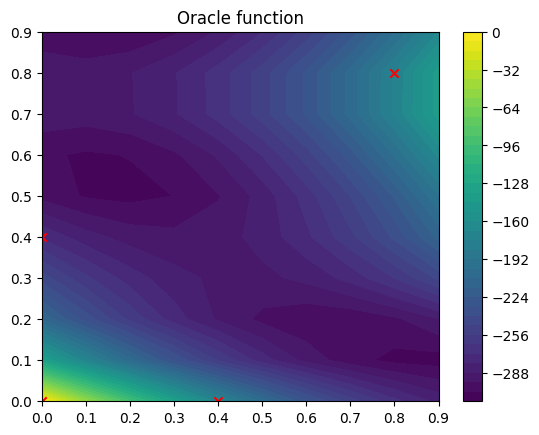

In [6]:
# Oracle
from gflownet.proxy.box.branin import Branin
oracle = Branin(fidelity=1, do_domain_map=True, device=device, float_precision=64)

# testing oracle
print(oracle(baseline_states.to(device).clone()/grid_size))

# plot oracle function
plot_function(oracle, grid_flat.clone(), scatter_markers=baseline_states/grid_size)
plt.title("Oracle function")
plt.show()

In [18]:
from importlib import reload  # Python 3.4+
import surrogate.surrogate as surrogate
reload(surrogate)

<module 'surrogate.surrogate' from '/home/mila/c/christina.humer/activelearning/my_package/surrogate/surrogate.py'>

tensor([0.7981], device='cuda:0', dtype=torch.float64) tensor([0.2281], device='cuda:0', dtype=torch.float64)


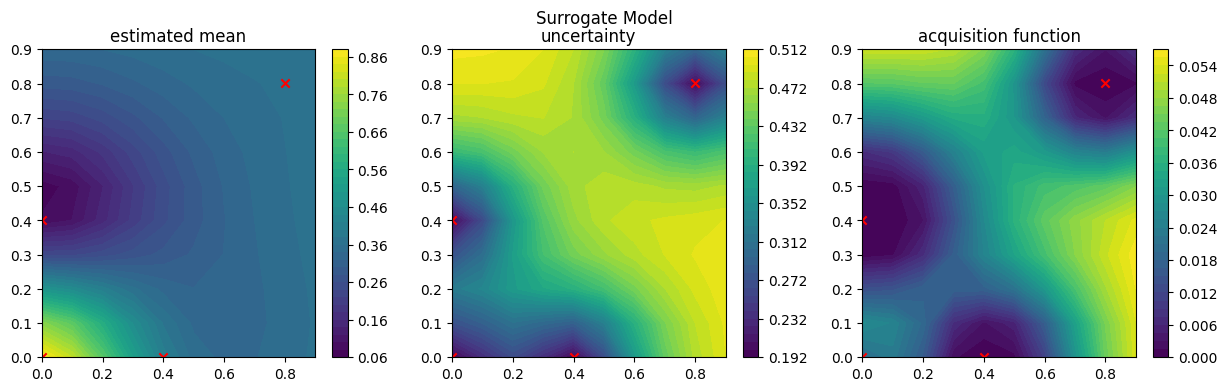

In [19]:
# Surrogate (e.g., Bayesian Optimization)
from surrogate.surrogate import SingleTaskGPRegressor
surrogate = SingleTaskGPRegressor(device=device, float_precision=64, maximize=False)
surrogate.fit(dataset_handler.train_data)

# testing surrogate
preds_mean, preds_var = surrogate.get_predictions(test_states/grid_size)
print(preds_mean, preds_var)

# plot surrogate functions
fig, axes = plt.subplots(ncols=3, figsize=(15,4))

plot_function(surrogate.get_predictions, grid_flat.clone(), fig=fig, ax=axes[0], scatter_markers=baseline_states/grid_size, output_index=0)
axes[0].set_title("estimated mean")

plot_function(surrogate.get_predictions, grid_flat.clone(), fig=fig, ax=axes[1], scatter_markers=baseline_states/grid_size, output_index=1)
axes[1].set_title("uncertainty")

plot_function(surrogate.get_acquisition_values, grid_flat.clone(), fig=fig, ax=axes[2], scatter_markers=baseline_states/grid_size)
axes[2].set_title("acquisition function")

fig.suptitle("Surrogate Model")
plt.show()

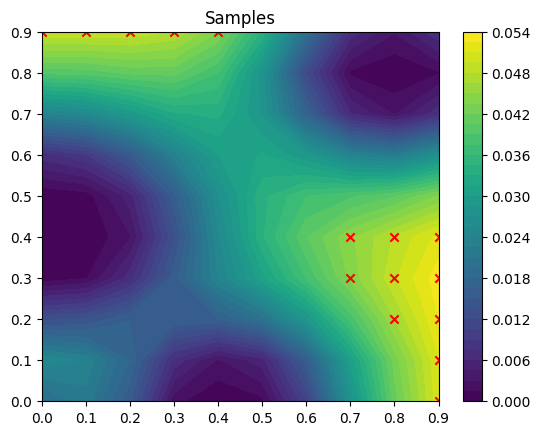

In [10]:
# Sampler (e.g., GFlowNet, or Random Sampler)
from sampler.sampler import GreedySampler, RandomSampler
sampler = GreedySampler(surrogate)
# sampler = RandomSampler(surrogate)
sampler.fit()
samples = sampler.get_samples(n_samples*3, grid_flat.clone()).cpu()

# plot acq function with proposed candidates
fig, ax = plot_function(surrogate.get_acquisition_values, grid_flat.clone(), scatter_markers=samples)
plt.title("Samples")
plt.show()

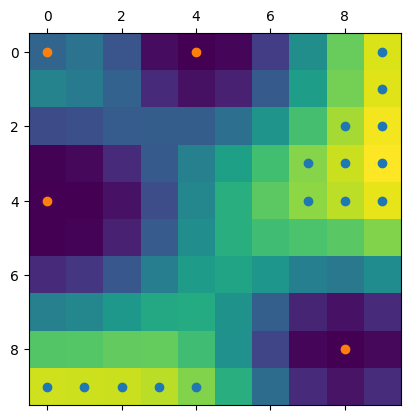

In [11]:
acq = surrogate.get_acquisition_values(grid_flat.clone()).detach().cpu()
plt.matshow(acq.reshape(int(len(acq)**(1/2)),int(len(acq)**(1/2))))
plt.scatter(samples.cpu()[:,1]*grid_size, samples.cpu()[:,0]*grid_size)
plt.scatter(baseline_states[:,1].cpu(), baseline_states[:,0].cpu())

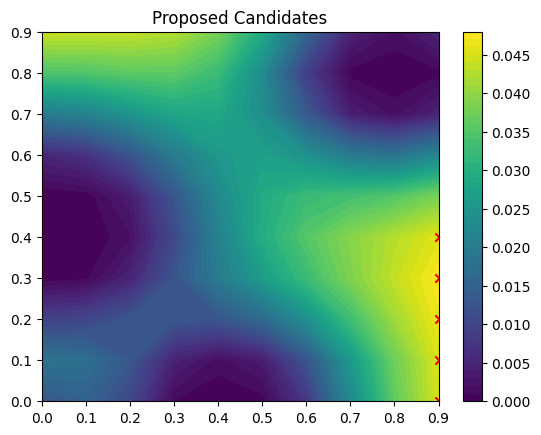

In [15]:
from filter.filter import Filter, OracleFilter

filter = Filter()
# filter = OracleFilter(oracle)
filtered_samples = filter(n_samples, samples)

# plot oracle function with proposed candidates
fig, ax = plot_function(surrogate.get_acquisition_values, grid_flat.clone(), scatter_markers=filtered_samples.to("cpu"))
plt.title("Proposed Candidates")
plt.show()

In [16]:
# Load Hydra config in notebooks
# https://github.com/facebookresearch/hydra/blob/main/examples/jupyter_notebooks/compose_configs_in_notebook.ipynb
import os
from hydra import initialize_config_dir, compose
from omegaconf import OmegaConf

abs_config_dir=os.path.abspath("config/")
with initialize_config_dir(version_base=None, config_dir=abs_config_dir):
    config_gflownet = compose(config_name="gflownet.yaml", overrides=[])
    # print(OmegaConf.to_yaml(env_config))
    print(config_gflownet)

# Logger
from gflownet.gflownet import GFlowNetAgent
# GFlowNetAgent()

{'seed': 0, 'optimizer': {'loss': 'flowmatch', 'lr': 0.0001, 'lr_decay_period': 1000000, 'lr_decay_gamma': 0.5, 'method': 'adam', 'early_stopping': 0.0, 'ema_alpha': 0.5, 'adam_beta1': 0.9, 'adam_beta2': 0.999, 'sgd_momentum': 0.9, 'batch_size': 32, 'train_to_sample_ratio': 1, 'n_train_steps': 20000, 'bootstrap_tau': 0.0, 'clip_grad_norm': 0.0}, 'batch_reward': True, 'mask_invalid_actions': True, 'temperature_logits': 1.0, 'random_action_prob': 0.001, 'pct_offline': 0.0, 'replay_capacity': 0, 'al': True, 'forward_policy': {'type': 'mlp', 'n_hid': 128, 'n_layers': 2, 'checkpoint': None, 'reload_ckpt': False}, 'backward_policy': {'type': 'uniform'}, 'ckpt_period': None, 'num_empirical_loss': 200000, 'oracle': {'n': 500}, 'sample_only': False, 'buffer': {'train': {'path': None, 'n': None, 'type': None, 'seed': None, 'output_csv': None}, 'test': {'path': None, 'type': 'all', 'output_pkl': 'buffer_data_test.csv', 'n': None, 'seed': None, 'output_csv': None}}}


In [20]:
from gflownet.envs.grid import Grid as GFlowNetGridEnv
grid_env = GFlowNetGridEnv(
        n_dim = 2,
        length = grid_size,
        max_increment = 1,
        max_dim_per_action = 1,
        cell_min = 0,
        cell_max = 1,
        proxy=surrogate # TODO: is the proxy a surrogate or an oracle?
)

In [21]:
from gflownet.gflownet import GFlowNetAgent
GFlowNetAgent(grid_env, device=device, float_precision=64, logger=None, **config_gflownet)


Constructing data set 
            Important: offline trajectories will NOT be sampled. In order to sample
            offline trajectories, the train configuration of the buffer should be
            complete and feasible and an output pkl file should be defined in
            env.buffer.train.output_pkl.
            

Constructing data set 

TypeError: 'SingleTaskGPRegressor' object is not callable

In [25]:
# Load Hydra config in notebooks
# https://github.com/facebookresearch/hydra/blob/main/examples/jupyter_notebooks/compose_configs_in_notebook.ipynb
import os
from hydra import initialize_config_dir, compose
from omegaconf import OmegaConf

abs_config_dir=os.path.abspath("config/")
with initialize_config_dir(version_base=None, config_dir=abs_config_dir):
    config_logger = compose(config_name="logger.yaml", overrides=[])
    # print(OmegaConf.to_yaml(env_config))
    print(config_logger)

# Logger
from utils.logger import Logger
logger = Logger(
    config=OmegaConf.create(), 
    **config_logger
)

{'do': {'online': True, 'times': True}, 'ckpts': {'policy': {'period': 5000}, 'regressor': {'period': 10}}, 'train': {'period': 1}, 'test': {'period': -1, 'n': 1, 'first_it': True, 'kde': {'bandwidth': 0.1, 'kernel': 'gaussian'}}, 'oracle': {'period': -1, 'k': [1, 10, 100]}, 'logdir': {'root': './logs', 'ckpts': 'ckpts', 'data': 'data', 'overwrite': True}, 'lightweight': False, 'progress': True, 'debug': False, 'project_name': 'MF-AL-GFN', 'tags': ['branin', 'sf']}


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: christina-humer. Use `wandb login --relogin` to force relogin


In [11]:
# # environment
# import config
# train = config.env.BufferSpec(
#     path="~/scratch/datasets/grid/corners_d2l3_r0.csv",
#     seed=167,
#     n=1000,
# )
# test = config.env.BufferSpec(
#     path="~/scratch/datasets/grid/corners_d2l3_r0.csv",
#     seed=167,
#     n=1000,
# )
# buffer = config.env.Buffer(train=train, test=test)
# config_env = config.env.Grid_Env(
#     buffer, 
#     min_step_len=1,
#     max_step_len=1,
#     cell_min=-1,
#     cell_max=1
# )

# from environment.grid_env import GridEnv
# env = GridEnv(**config_env.__dict__)